In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import seaborn as sns
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.collections import LineCollection

# Specifications

In [2]:
var = 'default' # Return period to plot
name = ''
space_thres = 3 # Spatial threshold
time_thres = 5  # Temporal threshold
num_thres = 7 # Minimum number of points to form a cluster
save = False
base_CPI = 313.3

disaster_name = 'KATRINA'
disaster_name2 = 'IKE'

if var == 'default':
    var = 'returnPeriod_MSWEP_1d'
    name = ''
    folder = ''
    space_thres = 3 # Spatial threshold
    time_thres = 5  # Temporal threshold
    num_thres = 7 # Minimum number of points to form a cluster
else:
    folder = 'SI/'

In [3]:
optimal_cluster = f'st_cluster_{space_thres}_{time_thres}_{num_thres}'
claim_num = -1
claim_num2 = -1

if disaster_name == 'KATRINA':
    claim_num = 4
    hist_CPI1 = 195.2666666666666667
elif disaster_name == 'IKE':
    claim_num = 8
    hist_CPI1 = 215.25425000000000002666666666666667
else:
    print("error, no disaster specified for claims")

if disaster_name2 == 'KATRINA':
    claim_num2 = 4
    hist_CPI2 = 195.2666666666666667
elif disaster_name2 == 'IKE':
    claim_num2 = 8
    hist_CPI2 = 215.25425000000000002666666666666667
else:
    print("error, no second disaster specified for claims")

In [4]:
# Keep text editable in Illustrator & compress rasters
mpl.rcParams.update({
    "pdf.fonttype": 42,      # TrueType text
    "ps.fonttype": 42,
    "pdf.compression": 9,
    "path.simplify": True,
    "path.simplify_threshold": 0.3,
})

# Rasterize non-line collections on an axes (good for polygon fills, bars, boxes)
def rasterize_non_lines(ax):
    for coll in ax.collections:
        coll.set_rasterized(True)
        coll.set_zorder(0)
    for patch in ax.patches:              # bars, box rectangles, violins
        patch.set_rasterized(True)
        patch.set_zorder(0)
    for art in getattr(ax, "artists", []):  # seaborn box patches live here
        if hasattr(art, "set_rasterized"):
            art.set_rasterized(True)
            art.set_zorder(0)
    for line in ax.lines:                 # whiskers, caps, medians, hlines
        line.set_rasterized(True)
        line.set_zorder(0)

# Load

## Geospatial

In [5]:
# Load the county shapefile
county_shapefile_path = '../../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Define the extent for the southern US
southern_us_extent = [-102, -65, 24, 50]

# Load county centroids
county_centroids = pd.read_csv("../county_centroids.csv")
county_centroids['GEOID'] = county_centroids['GEOID'].astype(int).astype(str)
county_centroids['GEOID'] = county_centroids['GEOID'].apply(lambda x: str(x).zfill(5))

## Disaster Declarations, Aid, Buyouts

In [6]:
# Load clustered disaster
disasters = pd.read_csv(f"../Clusters/clustered_disasters_sensitivity.csv")
disasters['fullFIPS'] = disasters['fullFIPS'].astype(int).astype(str)
disasters['fullFIPS'] = disasters['fullFIPS'].apply(lambda x: str(x).zfill(5))

owners_df = pd.read_csv("../no_percentile_filter/final_filtered_aid_owners.csv")
renters_df = pd.read_csv("../no_percentile_filter/final_filtered_aid_renters.csv")

# Concatenate the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)

# Replace NaNs with 0 and ensure all values are non-negative integers
filtered_aid_df['approvedForFemaAssistance'] = pd.to_numeric(
    filtered_aid_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].astype(int).astype(str)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

buyouts_df = pd.read_csv("../no_percentile_filter/final_filtered_buyouts.csv")
buyouts_df['countyCode'] = buyouts_df['countyCode'].astype(int).astype(str)
buyouts_df['countyCode'] = buyouts_df['countyCode'].apply(lambda x: str(x).zfill(5))

# Merge the dataframes
disasters = disasters.merge(
    filtered_aid_df[['disasterNumber', 'fullFIPS', 'approvedForFemaAssistance', 'totalApprovedIhpAmount']],
    on=['disasterNumber', 'fullFIPS'],
    how='left'  # Use 'left' to retain all rows from disasters
)

# Merge the dataframes
disasters = disasters.merge(
    buyouts_df[['disasterNumber', 'countyCode', 'numberOfProperties', 'actualAmountPaid']],
    left_on=['disasterNumber', 'fullFIPS'],
    right_on=['disasterNumber', 'countyCode'],
    how='left'  # Use 'left' to retain all rows from disasters
)

# Convert optimal_cluster to string
disasters[optimal_cluster] = disasters[optimal_cluster].astype(str)

disasters2 = disasters.copy()

/tmp/ipykernel_2653/3716395978.py:19: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  buyouts_df = pd.read_csv("../no_percentile_filter/final_filtered_buyouts.csv")


## Claims

In [7]:
# Load clustered claims
claims = pd.read_csv('../Clusters/no_percentile_filter/clustered_claims_sensitivity.csv')

claims['countyCode'] = claims['countyCode'].astype(int).astype(str)
claims['countyCode'] = claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Get the maximum spatiotemporal cluster label
max_st_cluster = claims[optimal_cluster].mode().iloc[0]

claims2 = claims.copy()

# Filter for points in the specified cluster
cluster_points = claims[claims[optimal_cluster] == claim_num]

# Create a GeoDataFrame for the points
gdf_claims_all = gpd.GeoDataFrame(
    cluster_points,
    geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
    crs="EPSG:4326"
)

# Katrina Sum Claims Damage
katrina_claim_sum = cluster_points['amountPaidOnBuildingClaim'].sum()+cluster_points['amountPaidOnContentsClaim'].sum()
katrina_claim_sum = katrina_claim_sum * (base_CPI/hist_CPI1)

# Filter for points in the specified cluster
cluster_points2 = claims2[claims2[optimal_cluster] == claim_num2]

# Create a GeoDataFrame for the points
gdf_claims_all2 = gpd.GeoDataFrame(
    cluster_points2,
    geometry=gpd.points_from_xy(cluster_points2['longitude'], cluster_points2['latitude']),
    crs="EPSG:4326"
)

# Ike Sum Claims Damage
ike_claim_sum = cluster_points2['amountPaidOnBuildingClaim'].sum()+cluster_points2['amountPaidOnContentsClaim'].sum()
ike_claim_sum = ike_claim_sum * (base_CPI/hist_CPI2)

/tmp/ipykernel_2653/274812196.py:2: DtypeWarning: Columns (8,26,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  claims = pd.read_csv('../Clusters/no_percentile_filter/clustered_claims_sensitivity.csv')


In [8]:
# Group by 'countyCode' and calculate counts
county_counts = cluster_points.groupby('countyCode').size().reset_index(name='claim_counts')

# Merge with the 'county_centroids' DataFrame on 'GEOID'
merged_df = county_centroids.merge(county_counts, left_on='GEOID', right_on='countyCode', how='left')

# Create a GeoDataFrame for plotting using gpd.points_from_xy
gdf_claims = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['centroid_lon'], merged_df['centroid_lat']),
    crs="EPSG:4326"
)

# Group by 'countyCode' and calculate counts
county_counts2 = cluster_points2.groupby('countyCode').size().reset_index(name='claim_counts')

# Merge with the 'county_centroids' DataFrame on 'GEOID'
merged_df2 = county_centroids.merge(county_counts2, left_on='GEOID', right_on='countyCode', how='left')

# Create a GeoDataFrame for plotting using gpd.points_from_xy
gdf_claims2 = gpd.GeoDataFrame(
    merged_df2,
    geometry=gpd.points_from_xy(merged_df2['centroid_lon'], merged_df2['centroid_lat']),
    crs="EPSG:4326"
)

In [9]:
# Assume disasters is already a DataFrame
# Filter the dataframe to only include Hurricane Katrina
hurricane = disasters[disasters['declarationTitle'] == f'HURRICANE {disaster_name}']
hurricane2 = disasters2[disasters2['declarationTitle'] == f'HURRICANE {disaster_name2}']

In [10]:
filtered_numbers = [num for num in set(hurricane[optimal_cluster]) if num != '-1']
# Extract the first number from filtered_numbers
if filtered_numbers:  # Check if the list is not empty
    first_number = filtered_numbers[0]

    # Replace all values in the column with the first number from filtered_numbers
    disasters[optimal_cluster] = disasters[optimal_cluster].apply(
        lambda x: first_number if x in filtered_numbers else x
    )

filtered_numbers = [num for num in set(hurricane[optimal_cluster]) if num != '-1']
number = filtered_numbers[0]

In [11]:
filtered_numbers2 = [num for num in set(hurricane2[optimal_cluster]) if num != '-1']
# Extract the first number from filtered_numbers
if filtered_numbers2:  # Check if the list is not empty
    first_number2 = filtered_numbers2[0]

    # Replace all values in the column with the first number from filtered_numbers
    disasters2[optimal_cluster] = disasters2[optimal_cluster].apply(
        lambda x: first_number2 if x in filtered_numbers2 else x
    )

filtered_numbers2 = [num for num in set(hurricane2[optimal_cluster]) if num != '-1']
number2 = filtered_numbers2[0]

In [12]:
# Filter the dataframe to only include Hurricane Katrina
cluster_x = disasters[disasters[optimal_cluster] == number]

# Compute median latitude, longitude, and daysSinceStart for each declarationTitle
median_data = cluster_x.groupby('declarationTitle').agg(
    median_lat=('centroid_lat', 'median'),
    median_lon=('centroid_lon', 'median'),
    median_daysSinceStart=('daysSinceStart', 'median')
).reset_index()

# Convert to GeoDataFrame for geospatial plotting
gdf_points = gpd.GeoDataFrame(
    cluster_x,
    geometry=gpd.points_from_xy(cluster_x['centroid_lon'], cluster_x['centroid_lat']),
    crs="EPSG:4326"
)

# Katrina Sum Disaster Aid Damage
katrina_disaster_sum = np.sum(list(set(cluster_x['totalApprovedIhpAmount'].fillna(0))))* (base_CPI/hist_CPI1)
katrina_buyouts_sum = np.sum(list(set(cluster_x['actualAmountPaid'].fillna(0)))) * (base_CPI/hist_CPI1)

# Filter the dataframe to only include Hurricane Ike
cluster_x2 = disasters2[disasters2[optimal_cluster] == number2]

# Compute median latitude, longitude, and daysSinceStart for each declarationTitle
median_data2 = cluster_x2.groupby('declarationTitle').agg(
    median_lat=('centroid_lat', 'median'),
    median_lon=('centroid_lon', 'median'),
    median_daysSinceStart=('daysSinceStart', 'median')
).reset_index()

# Convert to GeoDataFrame for geospatial plotting
gdf_points2 = gpd.GeoDataFrame(
    cluster_x2,
    geometry=gpd.points_from_xy(cluster_x2['centroid_lon'], cluster_x2['centroid_lat']),
    crs="EPSG:4326"
)

# Ike Sum Disaster Aid, Buyouts Damage
ike_disaster_sum = np.sum(list(set(cluster_x2['totalApprovedIhpAmount'].fillna(0)))) * (base_CPI/hist_CPI2)
ike_buyouts_sum = np.sum(list(set(cluster_x2['actualAmountPaid'].fillna(0)))) * (base_CPI/hist_CPI2)

In [13]:
# Custom color palette for mapping
colors = ['#007380', '#21BBBB', '#FFEFDB', '#ffcab7', '#ff9183']
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log normalization

# Yellow-to-red color map
cmap_approved = plt.cm.YlOrRd
log_norm = LogNorm(vmin=1, vmax=gdf_points['approvedForFemaAssistance'].max())
log_norm2 = LogNorm(vmin=1, vmax=gdf_claims['claim_counts'].max())
log_norm_2 = LogNorm(vmin=1, vmax=gdf_points2['approvedForFemaAssistance'].max())
log_norm2_2 = LogNorm(vmin=1, vmax=gdf_claims2['claim_counts'].max())

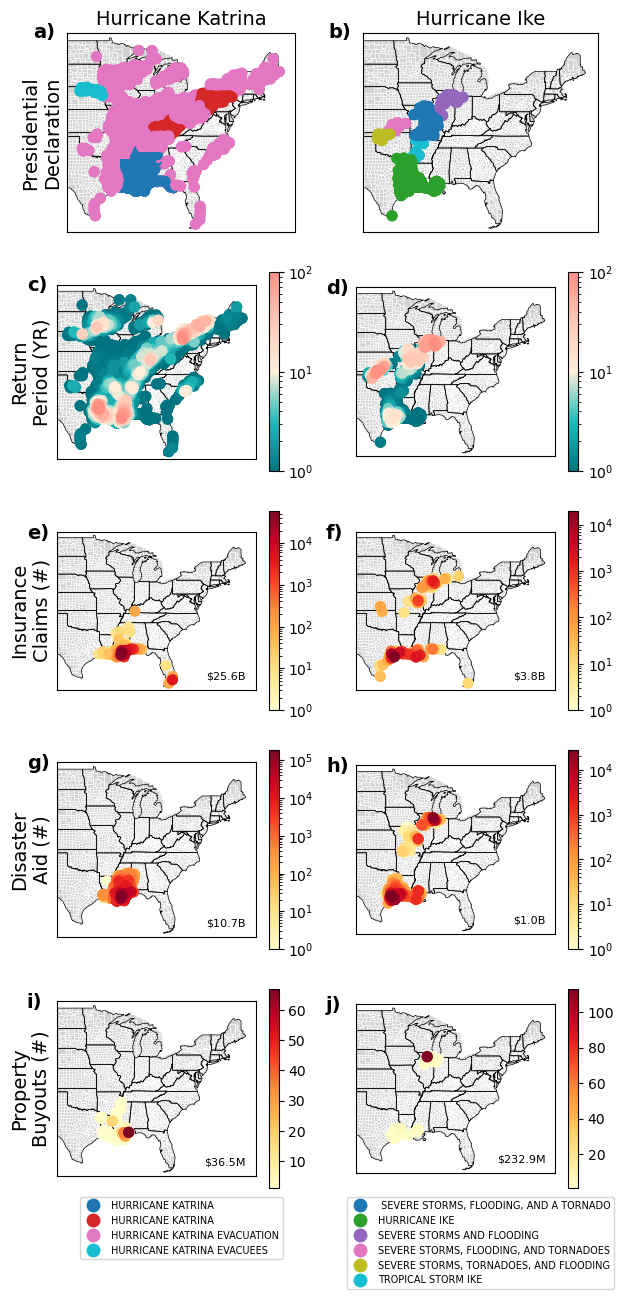

In [14]:
# Create the figure and subplots (5 vertical subplots)
fig, axes = plt.subplots(5, 2, figsize=(7.08, 15))

# First subplot: original plot
ax1 = axes[0,0]
gdf_counties.plot(ax=ax1, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax1, color='black', linewidth=0.5)
scatter = gdf_points.plot(
    ax=ax1,
    column='declarationTitle',
    cmap='tab10',
    markersize=50,
    legend=True,
    legend_kwds={'bbox_to_anchor': (0.5, -4.82), 'loc': 'upper center', 'ncol': 1, 'fontsize':7}

)

# Plot 1 settings (example for declarationTitle)
column1 = 'declarationTitle'
unique_values1 = gdf_points[column1].unique()
cmap1 = plt.get_cmap('tab10')
colors1 = {value: cmap1(idx / len(unique_values1)) for idx, value in enumerate(unique_values1)}

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax1)

# Set extent and labels for the first subplot
ax1.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax1.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax1.set_title('Hurricane Katrina', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Presidential\nDeclaration', fontsize=14)
ax1.axis('on')  # Turn on the axis
ax1.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax1.text(-0.15, 1.05, "a)", transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Second subplot: points colored by optimal_cluster with log colormap
ax2 = axes[1,0]
gdf_counties.plot(ax=ax2, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax2, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by=var, ascending=True)
gdf_points.plot(
    ax=ax2,
    column=var,
    cmap=cmap_left,
    markersize=50,
    legend=True,
    norm=norm
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax2)

# Set extent and labels for the second subplot
ax2.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax2.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax2.set_xlabel('')
ax2.set_ylabel('Return\nPeriod (YR)', fontsize=14)
ax2.axis('on')  # Turn on the axis
ax2.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax2.text(-0.15, 1.05, "c)", transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Third subplot: points colored by 'claim_counts' with yellow-red colormap
ax3 = axes[2,0]
gdf_counties.plot(ax=ax3, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax3, color='black', linewidth=0.5)
gdf_claims = gdf_claims.sort_values(by='claim_counts', ascending=True)
gdf_claims.plot(
    ax=ax3,
    column='claim_counts',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm2
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax3)

# Set extent and labels for the third subplot
ax3.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax3.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax3.set_xlabel('')
ax3.set_ylabel('Insurance\nClaims (#)', fontsize=14)
ax3.axis('on')  # Turn on the axis
ax3.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax3.text(-0.15, 1.05, "e)", transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${katrina_claim_sum / 1_000_000_000:.1f}B'
ax3.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax3.transAxes  # Use axes coordinates for positioning
)

# Fourth subplot: points colored by 'approvedForFemaAssistance' with yellow-red colormap
ax4 = axes[3,0]
gdf_counties.plot(ax=ax4, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax4, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by='approvedForFemaAssistance', ascending=True)
gdf_points.plot(
    ax=ax4,
    column='approvedForFemaAssistance',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax4)

# Set extent and labels for the fourth subplot
ax4.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax4.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax4.set_xlabel('')
ax4.set_ylabel('Disaster\nAid (#)', fontsize=14)
ax4.axis('on')  # Turn on the axis
ax4.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax4.text(-0.15, 1.05, "g)", transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${katrina_disaster_sum / 1_000_000_000:.1f}B'
ax4.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax4.transAxes  # Use axes coordinates for positioning
)

# Fifth subplot: points colored by 'numberOfProperties' with yellow-red colormap
ax5 = axes[4,0]
gdf_counties.plot(ax=ax5, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax5, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by='numberOfProperties', ascending=True)
gdf_points.plot(
    ax=ax5,
    column='numberOfProperties',
    cmap=cmap_approved,
    markersize=50,
    legend=True
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax5)

# Set extent and labels for the fifth subplot
ax5.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax5.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax5.set_xlabel('')
ax5.set_ylabel('Property\nBuyouts (#)', fontsize=14)
ax5.axis('on')  # Turn on the axis
ax5.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax5.text(-0.15, 1.05, "i)", transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${katrina_buyouts_sum / 1_000_000:.1f}M'
ax5.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax5.transAxes  # Use axes coordinates for positioning
)

# First subplot: original plot
ax6 = axes[0,1]
gdf_counties.plot(ax=ax6, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax6, color='black', linewidth=0.5)
scatter = gdf_points2.plot(
    ax=ax6,
    column='declarationTitle',
    cmap='tab10',
    markersize=50,
    legend=True,
    legend_kwds={'bbox_to_anchor': (0.5, -4.82), 'loc': 'upper center', 'ncol': 1, 'fontsize':7}
)

# Plot 6 settings (example for another column)
column6 = 'declarationTitle'
unique_values6 = gdf_points2[column6].unique()
cmap6 = plt.get_cmap('tab10')
colors6 = {value: cmap6(idx / len(unique_values6)) for idx, value in enumerate(unique_values6)}

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax6)

# Set extent and labels for the first subplot
ax6.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax6.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax6.set_title('Hurricane Ike', fontsize=14)
ax6.axis('on')  # Turn on the axis
ax6.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax6.text(-0.15, 1.05, "b)", transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Second subplot: points colored by optimal_cluster with log colormap
ax7 = axes[1,1]
gdf_counties.plot(ax=ax7, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax7, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by=var, ascending=True)
gdf_points2.plot(
    ax=ax7,
    column=var,
    cmap=cmap_left,
    markersize=50,
    legend=True,
    norm=norm
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax7)

# Set extent and labels for the second subplot
ax7.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax7.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax7.axis('on')  # Turn on the axis
ax7.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax7.text(-0.15, 1.05, "d)", transform=ax7.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Third subplot: points colored by 'claim_counts' with yellow-red colormap
ax8 = axes[2,1]
gdf_counties.plot(ax=ax8, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax8, color='black', linewidth=0.5)
gdf_claims2 = gdf_claims2.sort_values(by='claim_counts', ascending=True)
gdf_claims2.plot(
    ax=ax8,
    column='claim_counts',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm2_2
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax8)

# Set extent and labels for the third subplot
ax8.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax8.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax8.axis('on')  # Turn on the axis
ax8.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax8.text(-0.15, 1.05, "f)", transform=ax8.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${ike_claim_sum / 1_000_000_000:.1f}B'
ax8.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax8.transAxes  # Use axes coordinates for positioning
)

# Fourth subplot: points colored by 'approvedForFemaAssistance' with yellow-red colormap
ax9 = axes[3,1]
gdf_counties.plot(ax=ax9, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax9, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by='approvedForFemaAssistance', ascending=True)
gdf_points2.plot(
    ax=ax9,
    column='approvedForFemaAssistance',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm_2
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax9)

# Set extent and labels for the fourth subplot
ax9.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax9.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax9.axis('on')  # Turn on the axis
ax9.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax9.text(-0.15, 1.05, "h)", transform=ax9.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${ike_disaster_sum / 1_000_000_000:.1f}B'
ax9.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax9.transAxes  # Use axes coordinates for positioning
)

# Fifth subplot: points colored by 'numberOfProperties' with yellow-red colormap
ax10 = axes[4,1]
gdf_counties.plot(ax=ax10, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax10, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by='numberOfProperties', ascending=True)
gdf_points2.plot(
    ax=ax10,
    column='numberOfProperties',
    cmap=cmap_approved,
    markersize=50,
    legend=True
)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax10)

# Set extent and labels for the fifth subplot
ax10.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax10.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax10.axis('on')  # Turn on the axis
ax10.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
ax10.text(-0.15, 1.05, "j)", transform=ax10.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Format the number and display it in the lower right corner
formatted_text = f'${ike_buyouts_sum / 1_000_000:.1f}M'
ax10.text(
    0.95, 0.05,  # Position in axes coordinates (fraction of the plot area)
    formatted_text,
    fontsize=8,
    ha='right',  # Horizontal alignment
    va='bottom', # Vertical alignment
    transform=ax10.transAxes  # Use axes coordinates for positioning
)

# Show the plot
if save:
    plt.savefig('../Plots/'+folder+'F5'+name+'.pdf',
        format='pdf', dpi=500, bbox_inches='tight')
plt.show()